<a href="https://colab.research.google.com/github/pillaisamarth/clg-proj/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Libraries**

In [ ]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from pandas_datareader.data import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# **Setting Default plotting styles**

In [ ]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

# **Fetching Stock prices using yfinance Library**

In this section we will get stock prices over four years for Google and Microsoft. However, for analysis, we will focus on Google stock prices for this entire program

In [ ]:
tech_list = [
    'GOOG',
    'MSFT'
]

end = datetime.now()
start = datetime(end.year - 4, end.month, end.day)

for stocks in tech_list:
    globals()[stocks] = yf.download(stocks, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# **Function Definitions**

In This section, we will describe some functions later used in the program



In [ ]:
def min_max_1000(df):
  sd = df.copy()
  sd['Close'] = (sd['Close'] - sd['Close'].min()) / sd['Close'].max()
  sd['Close'] = sd['Close'] * 1000
  return sd

In [ ]:
from sklearn.model_selection import train_test_split
def data_split(X, y, test_size = 0.2):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
  return (X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score
def get_score(y_true, y_pred):
  return mean_squared_error(y_true, y_pred)

# Creating DataFrame for Google Stock prices




In [ ]:
df = pd.DataFrame(GOOG[['Close']].copy())
df.head()

,Close
Date,
2018-11-27,52.220501
2018-11-28,54.311501
2018-11-29,54.415001
2018-11-30,54.721500
2018-12-03,55.321499


In [ ]:
sd = df.copy()
sd.head()

,Close
Date,
2018-11-27,52.220501
2018-11-28,54.311501
2018-11-29,54.415001
2018-11-30,54.721500
2018-12-03,55.321499


In [ ]:
#trying xgboost
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
sd.tail()

,Close
Date,
2022-11-18,97.800003
2022-11-21,95.830002
2022-11-22,97.330002
2022-11-23,98.820000
2022-11-25,97.599998


# Splitting Data

In this section, we will split the data into train, test and validation sets. The data from the beginning of the time series to 01-Jan-2022 belongs to train set, data from 01-Jan-2022 to 05-June-2022 belongs to validation set and data from 05-June-2022 to the end of the time series belongs to the test set.

In [ ]:
# split the data from 1 jan 2022
# Note that we cannot use scaled data to perform validation (because it is used to imitate unseen data)
# However, we can use scaled data to imitate unseen data and later pass this to a linear regression model trained to convert scaled to 
# raw data
split_date_1 = '01-Jan-2022' #train to validate
split_date_2 = '05-June-2022' #validate to test
sd_train = sd.loc[sd.index <= split_date_1].copy()
sd_valid = sd.loc[(sd.index > split_date_1) & (sd.index < split_date_2)].copy()
sd_test = sd.loc[sd.index > split_date_2].copy()

In [ ]:
sd_test.tail(10)

,Close
Date,
2022-11-11,96.730003
2022-11-14,96.029999
2022-11-15,98.720001
2022-11-16,98.989998
2022-11-17,98.500000
2022-11-18,97.800003
2022-11-21,95.830002
2022-11-22,97.330002
2022-11-23,98.820000


In [ ]:
sd_test.head()

,Close
Date,
2022-06-06,117.010498
2022-06-07,117.229500
2022-06-08,117.237999
2022-06-09,114.917999
2022-06-10,111.427498


In [ ]:
X_train, y_train = create_features(sd_train, label = 'Close')
X_valid, y_valid = create_features(sd_valid, label = 'Close')
X_test, y_test = create_features(sd_test, label = 'Close')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app


In [ ]:
X_train.head(10)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2018-11-27,0,1,4,11,2018,331,27,48
2018-11-28,0,2,4,11,2018,332,28,48
2018-11-29,0,3,4,11,2018,333,29,48
2018-11-30,0,4,4,11,2018,334,30,48
2018-12-03,0,0,4,12,2018,337,3,49
2018-12-04,0,1,4,12,2018,338,4,49
2018-12-06,0,3,4,12,2018,340,6,49
2018-12-07,0,4,4,12,2018,341,7,49
2018-12-10,0,0,4,12,2018,344,10,50


In [ ]:
X_valid.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2022-01-03,0,0,1,1,2022,3,3,1
2022-01-04,0,1,1,1,2022,4,4,1
2022-01-05,0,2,1,1,2022,5,5,1
2022-01-06,0,3,1,1,2022,6,6,1
2022-01-07,0,4,1,1,2022,7,7,1


# Creating Gradient Boosting model

In [ ]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=1000, objective = 'reg:squarederror')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=50,
       verbose=False) 

XGBRegressor(n_estimators=1000, objective='reg:squarederror')

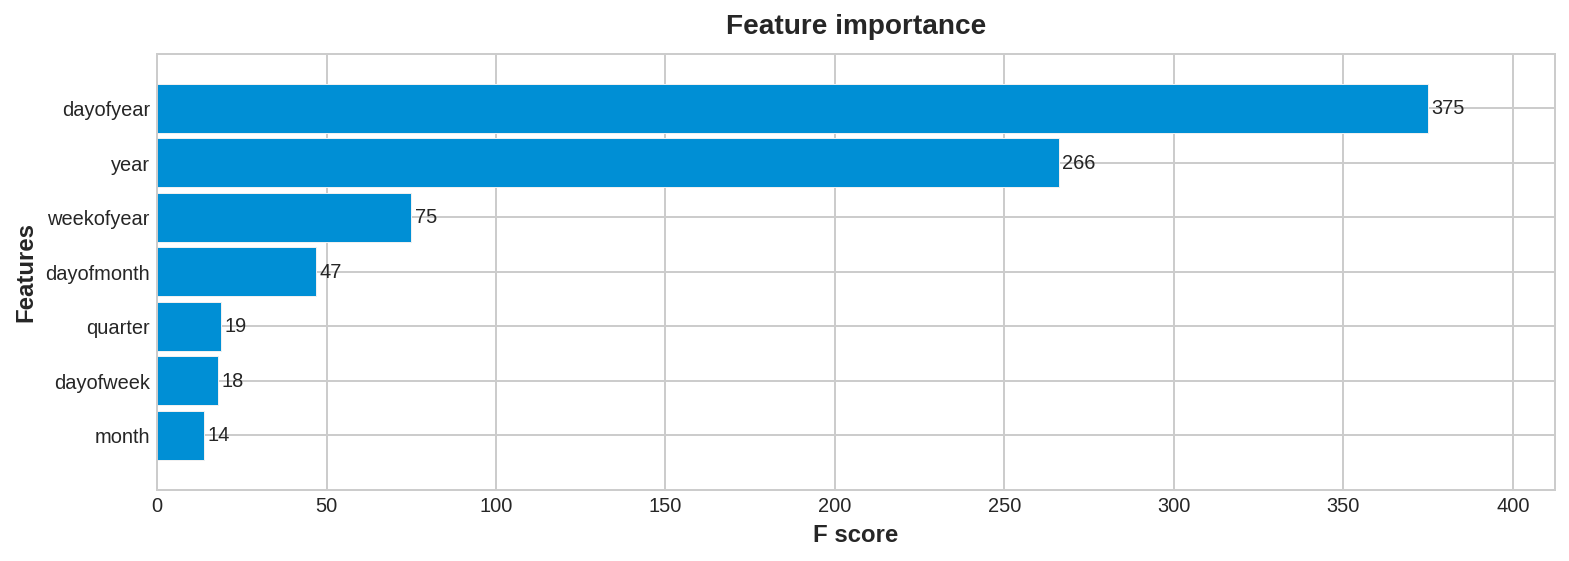

In [ ]:
_ = xgb.plot_importance(reg, height = 0.9)

In [ ]:
sd_test['predictions'] = reg.predict(X_test)
sd_test.head()
# predictions['Close'] = reg.predict(X_test)

,Close,predictions
Date,,
2022-06-06,117.010498,123.926231
2022-06-07,117.229500,123.926231
2022-06-08,117.237999,124.035324
2022-06-09,114.917999,124.446716
2022-06-10,111.427498,126.012726


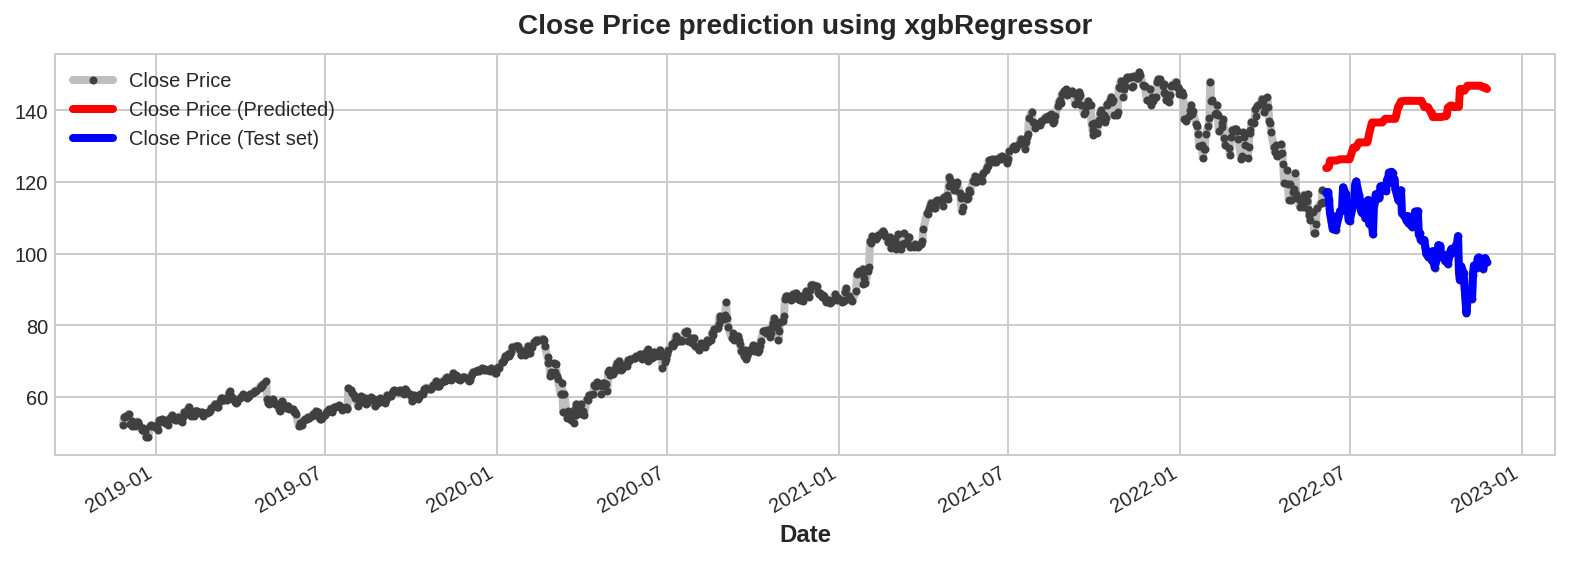

In [ ]:
ax = sd.plot(**plot_params)
ax = sd_test['predictions'].plot(ax = ax, color = 'r')
ax = y_test.plot(color = 'b')
ax.set_title('Close Price prediction using xgbRegressor')
ax.legend(['Close Price', 'Close Price (Predicted)', 'Close Price (Test set)'])

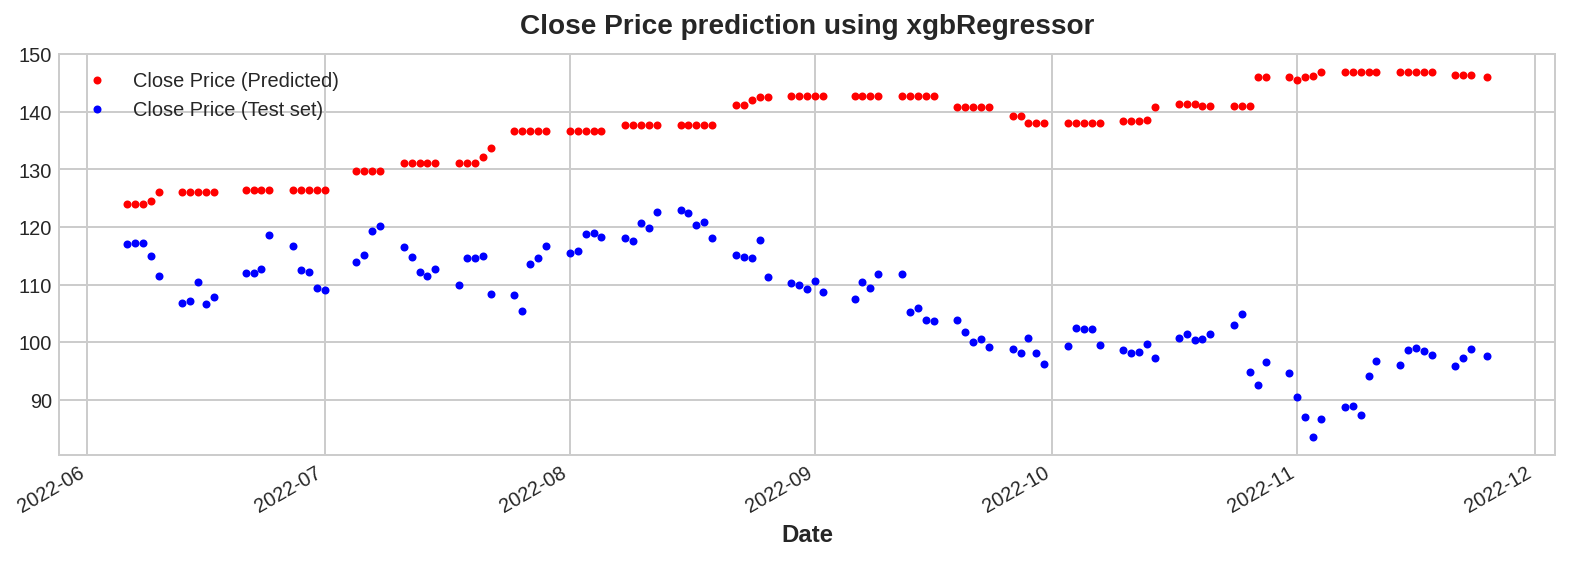

In [ ]:
ax = sd_test['predictions'].plot(color = 'r', style = '.')
ax = y_test.plot(color = 'b', style = '.')
ax.set_title('Close Price prediction using xgbRegressor')
ax.legend(['Close Price (Predicted)', 'Close Price (Test set)'])

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true = sd_test['Close'], y_pred = sd_test['predictions'])

30.10633667345252

In [ ]:
sd_train.head()

,Close
Date,
2018-11-27,52.220501
2018-11-28,54.311501
2018-11-29,54.415001
2018-11-30,54.721500
2018-12-03,55.321499
